# VARIATIONAL AUTOENCODER

https://arxiv.org/pdf/1312.6114.pdf

In [2]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import seaborn as sb 
sb.set_style( "darkgrid")

# Dataset

## Define the dataset

In [3]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw




Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# In this case the train_transform and test_transform are the same, but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])


In [5]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [6]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Autoencoder

In [7]:
class Encoder(nn.Module):
    def __init__(self, conv1):
        super(Encoder, self).__init__()
                ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, conv1, 4, stride=2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(conv1, conv1*2, 4, stride=2, padding=1),
            nn.ReLU(True),
        )
         ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)#dimension 0 is the sample, so we flatten from dimension 1
        
        self.fc_mu = nn.Linear(in_features=conv1*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=conv1*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
         # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers        
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    def __init__(self, conv1):
        super(Decoder, self).__init__()
        
        self.fc = nn.Linear(in_features=latent_dims, out_features=conv1*2*7*7)
        
        
        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(conv1*2, 7,7))

         ### Convolutional section
        self.decoder_conv = nn.Sequential(

            # 1 transposed convolution
            nn.ConvTranspose2d(conv1*2, conv1,4, stride=2, padding=1, output_padding=0),
            nn.ReLU(True),

            # 2 transposed convolution
            nn.ConvTranspose2d(conv1, 1,4, stride=2, padding=1, output_padding=0)
        )
         
    def forward(self, x):
      # Unflatten
        x = self.fc(x)
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)       
        return x
    
class VariationalAutoencoder(nn.Module):
    def __init__(self, conv1):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(conv1)
        self.decoder = Decoder(conv1)
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

In [8]:
### Set the random seed for reproducible results
torch.manual_seed(0)

latent_dims = 2
num_epochs = 100
batch_size = 128
conv1 = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

encoder = Encoder(conv1= conv1)
decoder = Decoder(conv1 = conv1)

In [9]:
### Some examples
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)
# Encode the image
img_enc, _ = encoder(img)
print('Encoded image shape:', img_enc.shape)
# Decode the image
dec_img = decoder(img_enc)
print('Decoded image shape:', dec_img.shape)

Original image shape: torch.Size([1, 1, 28, 28])
Encoded image shape: torch.Size([1, 2])
Decoded image shape: torch.Size([1, 1, 28, 28])


In [10]:
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + variational_beta * kldivergence
    
    

vae = VariationalAutoencoder(conv1)

In [11]:
import torch.nn.functional as F
### Set the random seed for reproducible results
torch.manual_seed(0)

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
vae = vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 308357


In [12]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

def train(num_epochs, optimizer):
  
  # set to training mode
  vae.train()

  train_loss_avg = []


  for epoch in range(num_epochs):
      train_loss_avg.append(0)
      num_batches = 0
      
      for image_batch, _ in train_dataloader:
          
          image_batch = image_batch.to(device)

          # vae reconstruction
          image_batch_recon, latent_mu, latent_logvar = vae(image_batch)
          
          # reconstruction error
          loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)
          
          # backpropagation
          optimizer.zero_grad()
          loss.backward()
          
          # one step of the optmizer (using the gradients from backpropagation)
          optimizer.step()
          train_loss_avg[-1] += loss.item()
          num_batches += 1

      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))
  return train_loss_avg

In [13]:
train_loss_avg = train(num_epochs, optimizer)

Epoch [1 / 100] average reconstruction error: 51581.385996
Epoch [2 / 100] average reconstruction error: 44214.597640
Epoch [3 / 100] average reconstruction error: 43016.757459
Epoch [4 / 100] average reconstruction error: 41969.428532
Epoch [5 / 100] average reconstruction error: 41119.053565
Epoch [6 / 100] average reconstruction error: 40506.888855
Epoch [7 / 100] average reconstruction error: 40095.508602
Epoch [8 / 100] average reconstruction error: 39798.979737
Epoch [9 / 100] average reconstruction error: 39562.325511
Epoch [10 / 100] average reconstruction error: 39375.808523
Epoch [11 / 100] average reconstruction error: 39220.512512
Epoch [12 / 100] average reconstruction error: 39087.232912
Epoch [13 / 100] average reconstruction error: 38955.055947
Epoch [14 / 100] average reconstruction error: 38890.541681
Epoch [15 / 100] average reconstruction error: 38759.173575
Epoch [16 / 100] average reconstruction error: 38671.367424
Epoch [17 / 100] average reconstruction error: 38

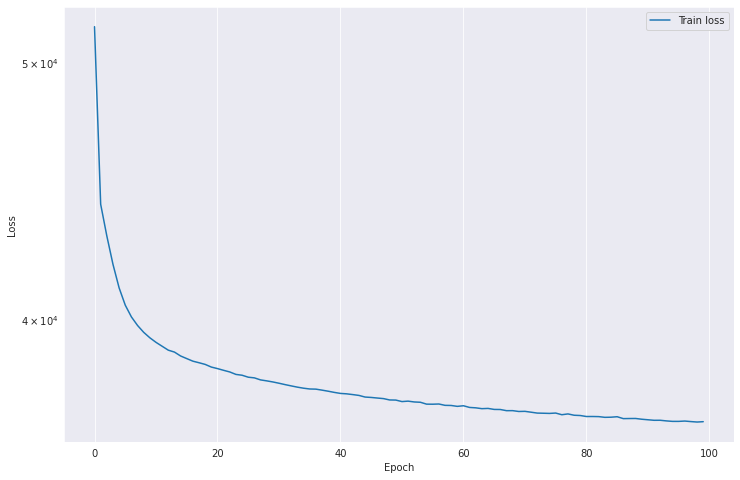

In [14]:
# Plot losses of the best model
plt.figure(figsize=(12,8))
plt.semilogy(train_loss_avg, label='Train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.grid()
plt.show() 

In [15]:
def test():
  # set to evaluation mode
  vae.eval()

  test_loss_avg, num_batches = 0, 0
  for image_batch, _ in test_dataloader:
      
      with torch.no_grad():
      
          image_batch = image_batch.to(device)

          # vae reconstruction
          image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

          # reconstruction error
          loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

          test_loss_avg += loss.item()
          num_batches += 1
      
  test_loss_avg /= num_batches
  print('average reconstruction error: %f' % (test_loss_avg))

In [16]:
test()

average reconstruction error: 37676.392151


Original images


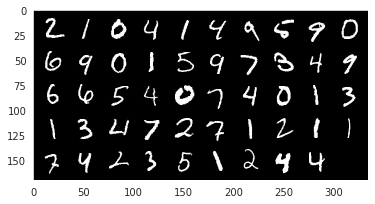

VAE reconstruction:


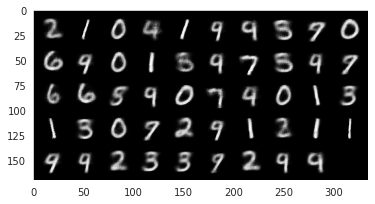

In [17]:
### Visualize reconstruction
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.grid()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.grid()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

reconstruc images from latent vectors

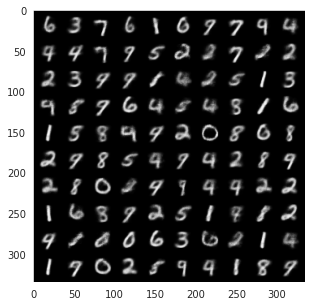

In [23]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

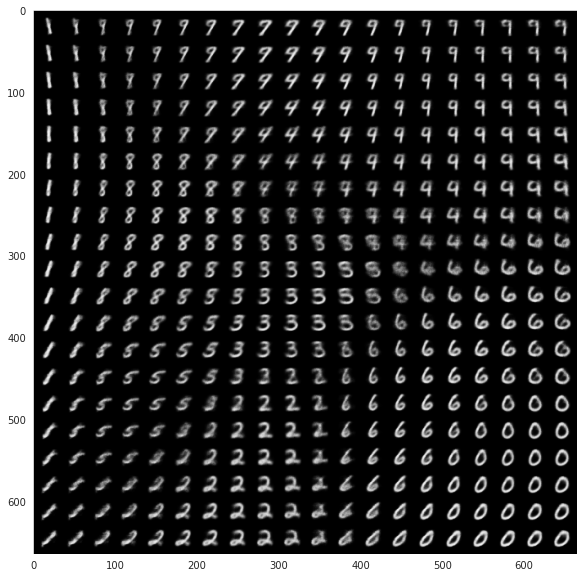

In [24]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()

In [25]:
### Get the encoded representation of the test samples
encoded_space_dim = 2
encoded_samples = []
enc_aut = np.zeros(encoded_space_dim+1)
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.encoder.eval()
    with torch.no_grad():
        encoded_img, _  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    enc_aut = np.vstack( (enc_aut, np.hstack( (encoded_img, label)) ) )

100%|██████████| 10000/10000 [00:06<00:00, 1613.86it/s]


In [26]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,label
0,0.145378,-2.327647,7
1,-0.010204,0.633348,2
2,-2.714688,-0.257289,1
3,1.075537,0.979056,0
4,0.776832,-0.268921,4
...,...,...,...
9995,-0.258177,1.014410,2
9996,-0.045530,0.285570,3
9997,0.024689,-1.334432,4
9998,-1.074161,0.542331,5


In [27]:
import plotly.express as px
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [28]:
encoded_space_dim = 2

In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score

# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

# PCA
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(encoded_samples.iloc[:,0:encoded_space_dim])
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( pca.transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns )

if n_components == 2:
    fig = px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)
elif n_components == 3:
    fig = px.scatter_3d(compressed_samples,  x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
                    color=encoded_samples.label.astype(str), opacity=0.7)
fig.show()



In [31]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

# TSNE
n_components = 2
tsne = TSNE(n_components=n_components)
tsne.fit(encoded_samples.iloc[:, 0:encoded_space_dim])
columns = [ f'Enc. Variable {i}' for i in range(n_components)]
compressed_samples = pd.DataFrame( tsne.fit_transform(encoded_samples.iloc[:,0:encoded_space_dim]), columns=columns )

if n_components == 2:
    fig = px.scatter(compressed_samples, x='Enc. Variable 0', y='Enc. Variable 1', 
           color=encoded_samples.label.astype(str), opacity=0.7)
elif n_components == 3:
    fig = px.scatter_3d(compressed_samples,  x='Enc. Variable 0', y='Enc. Variable 1', z='Enc. Variable 2',
                    color=encoded_samples.label.astype(str), opacity=0.7)
fig.show()